# Utils.Display

> Fill in a module description here


In [ ]:
#| default_exp utils.display

In [ ]:
#| export
from fastcore.utils import *
from fastcore.utils import *
import cv2
import numpy as np
from imutils import resize
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.showdoc import *
from fastcore.test import *


In [ ]:
#|export
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

In [ ]:
#|export

# Todo Test for ipython  see def in_ipython(): in fastcore  or imports.py
def show_image(im
               , ax=None  # if None, a new figure is created
               , figsize=None # if None, the figure size is set to min of 5 and max of 1/32 of the image size
               , title=None # title of the image
               , text=None # text to be written on image
               , fontsize=12 # fontsize of text
               , ctx=None # context
               , **kwargs # kwargs for matplotlib
    )->plt.Axes: # return matplotlib axis
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.ndarray(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    
    if text is not None:
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        # Compute the height of the image in data units
        image_height = ymax - ymin
        image_width = xmax - xmin
        # Set the position of the text to be 10% of the image height
        text_height = -0.1 * image_height
        text_width = 0.05 * image_width
        xpos = text_width
        ypos = text_height
        ax.text(xpos, ypos, text, fontsize=fontsize, bbox=dict(facecolor='white', edgecolor='none', pad=0)) 
        
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

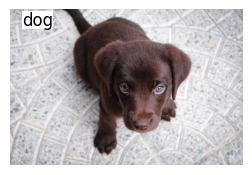

In [ ]:
im2 = np.array(Image.open(TEST_IMAGE))
ax = show_image(im2, text='dog', figsize=(3,3))

In [ ]:
#| export
def puttext(img
            , text:str    # text to be written on image
            , pos=(40,80)  # position of text
            , fontscale=2.0 # fontscale of text
            , thickness=2    # thickness of text
            , textcolor=(255,255,255)   # color of text
            , backcolor=(0,0,0)):   # color of background
    """ Place text on the image, the default position is the center of the image"""
    
    text_width, text_height = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontscale, 1)[0]
    
    if pos is None:
        pos = (img.shape[1]//2-text_width//2, img.shape[0]//2+text_height//2)
    
    rs_point = (pos[0]-2, pos[1]+2)
    re_point = (pos[0]+text_width+4, pos[1]-text_height-2)
    img = cv2.rectangle(img, rs_point, re_point, backcolor, -1)
    return cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, fontscale, textcolor, thickness, cv2.LINE_AA)

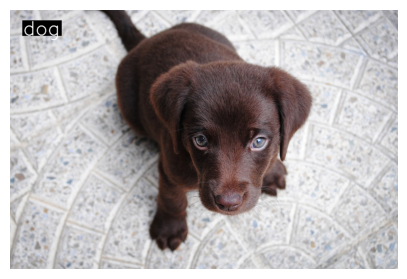

In [ ]:
im2 = np.array(Image.open(TEST_IMAGE))
im2 = puttext(im2, 'dog')
ax = show_image(im2)

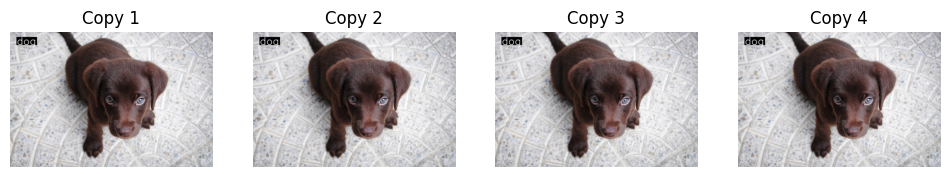

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,4))
for i,ax in enumerate(axs): show_image(im2, ax=ax, title=f'Copy {i+1}')

In [ ]:
#| export
class ScrollingLog:
    """Draws a  scrolling log of messages onto an image"""
    def __init__(self, 
                 max_lines:int=5, # max number of lines to display
                 position:tuple|None=None, # position of the log (x, y) or None
                 color:tuple=(255, 0, 0), # color of the log
                 bg_color:tuple|None=None, # background color of the log
                 thickness:int=2, # thickness of the log
                 font_scale:float=1.0, # font scale of the log
                 ): 

        self.max_lines = max_lines
        self.color = color
        self.bg_color = bg_color
        self.thickness = thickness
        self.font_scale = font_scale
        self.position = position
        self.log = []
        
    def update(self, message:str,  # add a message to the log
               index=None): # index of the message to be updated
        """Add a message to the log, if index is specified, update the message at the index"""
        if index is not None:
            # Replace message at the specified index
            if 0 <= index < len(self.log):
                self.log[index] = message

            else:
                print(f"Warning:  0 <= index < len(self.log)")
                self.log[-1] = message
        else:
            # Normal scrolling log behavior or index out of range
            self.log.append(message)
            if len(self.log) > self.max_lines:
                self.log.pop(0)
                
    def draw(self, image, font=cv2.FONT_HERSHEY_SIMPLEX):
        """Draw the log on the image"""
        if len(self.log) == 0:
            return
        # Calculate the font size based on the image size
        font_size = (self.font_scale * image.shape[0]) / 1000.0
        (_, line_height), _ = cv2.getTextSize(self.log[0], font, font_size, self.thickness)
        # line_height = int(font_size * 30)
        line_height = int(line_height * 1.5)
        if self.position is None:
            self.position = (line_height, line_height)
        
        # Draw background rectangles first  so no to overwrite the text hanging parts  
        y_offset = 0
        if self.bg_color is not None:
            for message in self.log:
                y = self.position[1] + y_offset
                # Getting the text size to create the background rectangle
                (text_width, text_height), _ = cv2.getTextSize(message, font, font_size, self.thickness)
                rectangle_start = (self.position[0], y - text_height - 5)
                rectangle_end = (self.position[0] + text_width, y+15)
                # Drawing the background rectangle
                cv2.rectangle(image, rectangle_start, rectangle_end, self.bg_color, -1)
                y_offset += line_height

        # draw text on background rectangle
        y_offset = 0
        for message in self.log:
            y = self.position[1] + y_offset
            cv2.putText(image, message, (self.position[0], y), font, font_size, self.color, self.thickness)
            y_offset += line_height



In [ ]:
show_doc(ScrollingLog.update)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/utils/display.py#L106){target="_blank" style="float:right; font-size:smaller"}

### ScrollingLog.update

>      ScrollingLog.update (message:str, index=None)

Add a message to the log, if index is specified, update the message at the index

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| message | str |  | add a message to the log |
| index | NoneType | None | index of the message to be updated |

In [ ]:
show_doc(ScrollingLog.draw)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/utils/display.py#L123){target="_blank" style="float:right; font-size:smaller"}

### ScrollingLog.draw

>      ScrollingLog.draw (image, font=0)

Draw the log on the image

**Run some tests**

In [ ]:
image = np.array(Image.open(TEST_IMAGE))
log = ScrollingLog()
test_eq(log.draw(image), None)   # runs with no log present
for i in range(10):
    log.update(f"Message {i}")

test_eq(log.log[0], "Message 5")
test_eq(log.log[-1], "Message 9")
test_eq(len(log.log), 5)
log.draw(image)

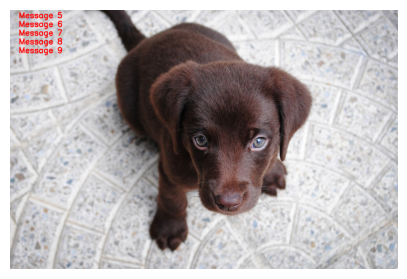

In [ ]:
ax = show_image(image)

In [ ]:
#| export

import logging

class ScrollingLogHandler(logging.Handler):
    def __init__(self, scrolling_log):
        super().__init__()
        self.scrolling_log = scrolling_log

    def emit(self, record):
        log_entry = self.format(record)
        self.scrolling_log.update(log_entry)

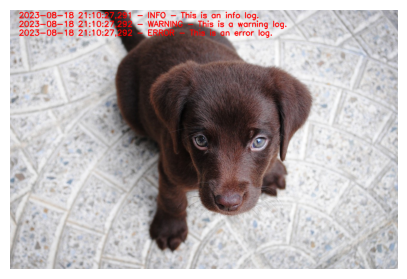

In [ ]:

# Setting up logging
log = ScrollingLog()
handler = ScrollingLogHandler(log)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Example usage:
logger.info("This is an info log.")
logger.warning("This is a warning log.")
logger.error("This is an error log.")

# Display the logs using OpenCV or your desired method
# image = cv2.imread("path_to_image.jpg")
image = np.array(Image.open(TEST_IMAGE))
log.draw(image)
ax = show_image(image)
# cv2.imshow('Logged Image', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2.waitKey(2000)
# cv2.destroyAllWindows()


### Example of use  ScrollingLog with index

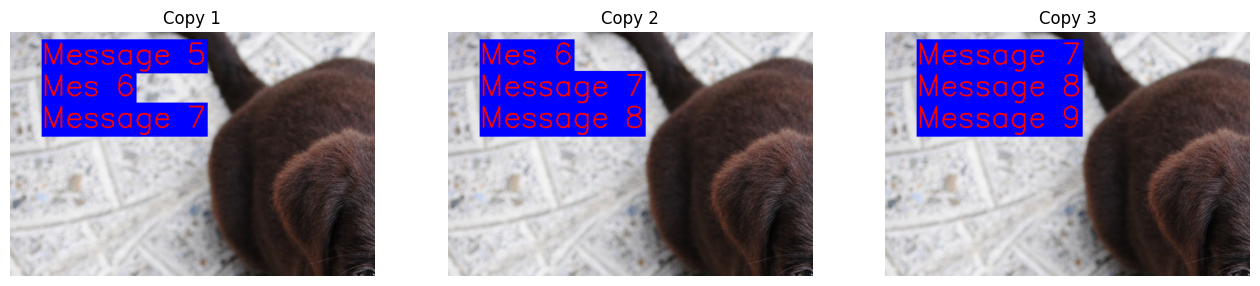

In [ ]:

# Simulate sequence of images

image = np.array(Image.open(TEST_IMAGE))
def test_log(image, max_lines=3, font_scale=2.0, index=None, bg_color=None):
    log = ScrollingLog(max_lines=max_lines, font_scale=font_scale, bg_color=bg_color)
    
    # Update log messages
    for i in range(6):
        log.update(f"Message {i}")
    log.update(f"Mes {i+1}")
    
    _,axs = plt.subplots(1,3,figsize=(16,8))
    for i,ax in enumerate(axs.flatten()): 
        img_copy = image.copy()
        log.update(f"Message {i + 7}", index=index)
        log.draw(img_copy)
        # just show the top left corner of the image
        img_copy = img_copy[:img_copy.shape[0]//2, :img_copy.shape[1]//2]
        show_image(img_copy, ax=ax, title=f'Copy {i+1}')

test_log(image, max_lines=3, font_scale=2.0, index=None, bg_color=(0,0,255))

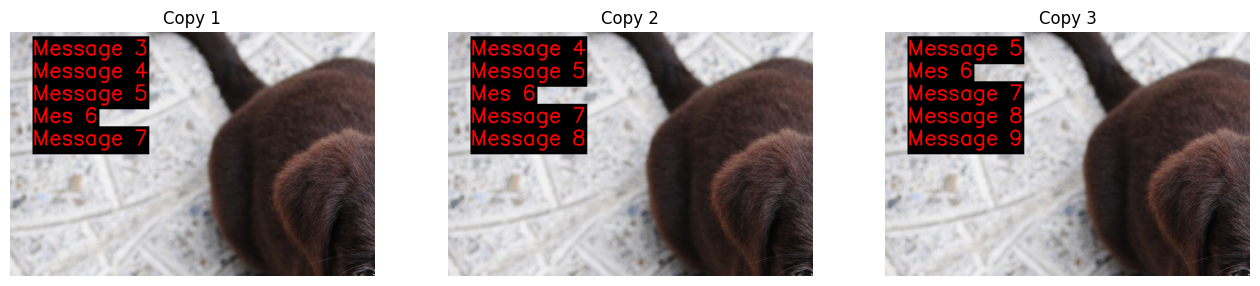

In [ ]:
test_log(image, max_lines=5, font_scale=1.4, index=None, bg_color=(0,0,0))

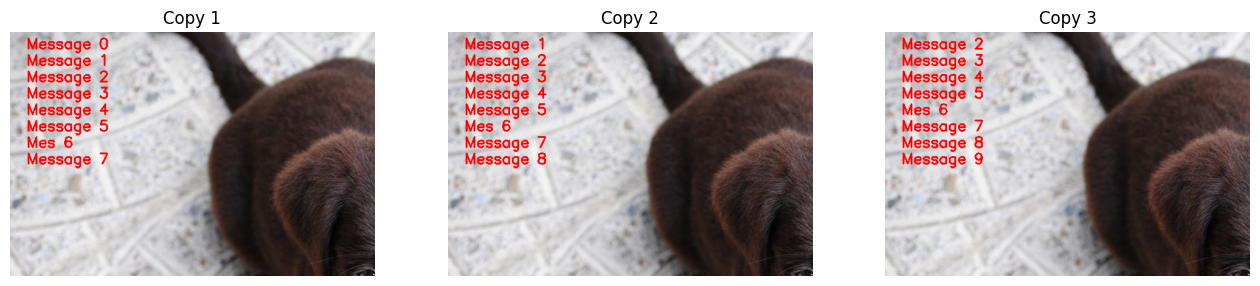

In [ ]:
test_log(image, max_lines=8, font_scale=1.0, index=None)

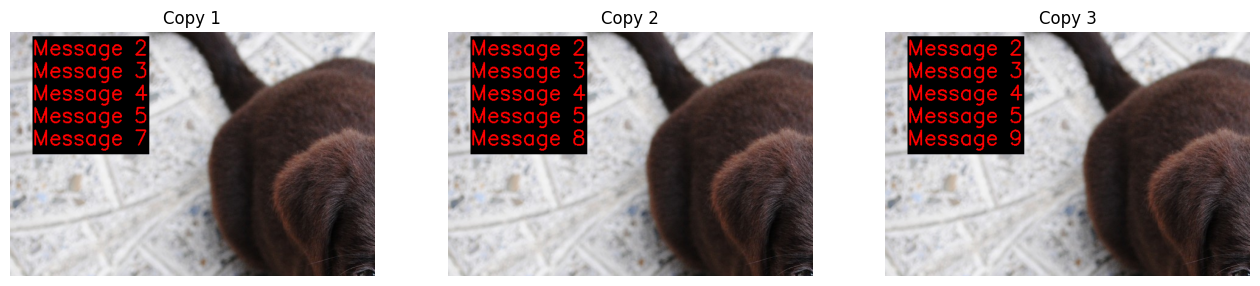

In [ ]:
test_log(image, max_lines=5, font_scale=1.4, index=6, bg_color=(0,0,0))



In [ ]:
#| hide 
# # don't go beyond here with Run All
# assert False, "Stoping Notebook Execution"

In [ ]:
#| export
class VideoWriter:
    """A wrapper around FFMPEG_VideoWriter to write videos from images"""
    def __init__(self, 
                 filename:str='_autoplay.mp4', # default filename
                 fps:float=30.0, #    fps of video
                 bgr2rgb:bool=False, # convert to RGB
                 **kw): # kwargs for FFMPEG_VideoWriter
        self.writer = None
        self.bgr2rgb=bgr2rgb,
        self.params = dict(filename=filename, fps=fps, **kw)
        print(f"Writing video to {Path.cwd()/filename} at {fps} fps.")

    def add(self, 
            img:np.ndarray # image to be added
            )->None:
        """Add an image to the video"""
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        if self.bgr2rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        """Show the video"""
        self.close()
        fn = self.params['filename']
        print (f"Video: {Path.cwd()/fn}")
        display(mvp.ipython_display(fn, **kw))

In [ ]:
show_doc(VideoWriter.add)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/utils/display.py#L182){target="_blank" style="float:right; font-size:smaller"}

### VideoWriter.add

>      VideoWriter.add (img:numpy.ndarray)

Add an image to the video

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| img | ndarray | image to be added |
| **Returns** | **None** |  |

In [ ]:
show_doc(VideoWriter.close)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/utils/display.py#L198){target="_blank" style="float:right; font-size:smaller"}

### VideoWriter.close

>      VideoWriter.close ()

In [ ]:
show_doc(VideoWriter.show)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/utils/display.py#L210){target="_blank" style="float:right; font-size:smaller"}

### VideoWriter.show

>      VideoWriter.show (**kw)

Show the video

In [ ]:
#|eval: false
import cv2
from UAV.utils.display import VideoWriter, ScrollingLog, ScrollingLogHandler, puttext
import numpy as np
from PIL import Image
from fastcore.test import *
import logging


log = ScrollingLog(bg_color=(0,0,0))
handler = ScrollingLogHandler(log)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

img = np.array(Image.open(TEST_IMAGE))
framecounter = 0
with VideoWriter("images/videowriter_test.mp4", 5.0) as video:

    for i in range(100):
        puttext(img, f"Frame: {framecounter}", pos=(700,80))
        logger.info(f"Frame: {framecounter}")
        log.draw(img)
        # cv2.imshow('image', img)
        # k = cv2.waitKey(100)
        # if k == 27 or k == ord('q') or k == ord('Q'):
        #     break
        video.add(img)
        framecounter += 1
# cv2.destroyAllWindows()
video.show(width=500)

Writing video to /home/jn/PycharmProjects/UAV/nbs/api/images/videowriter_test.mp4 at 5.0 fps.
Video: /home/jn/PycharmProjects/UAV/nbs/api/images/videowriter_test.mp4


In [ ]:
#| hide
# import nbdev; nbdev.nbdev_export()